In [1]:
!pip install -q tensorflowjs
!pip install jax-unirep
!nvidia-smi

     |████████████████████████████████| 77 kB 1.4 MB/s 
     |████████████████████████████████| 462 kB 10.9 MB/s 
     |████████████████████████████████| 77.0 MB 64 kB/s 
     |████████████████████████████████| 308 kB 57.0 MB/s 
     |████████████████████████████████| 210 kB 66.1 MB/s 
     |████████████████████████████████| 81 kB 7.8 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 150 kB 48.6 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 113 kB 44.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=a543bceb198852921bddf4df74a7424c631ef3d24826f311a3f1eda1f343a497
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and ru

In [2]:
#@title Runtime
use_tpu = False #@param

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
import json
np.random.seed(0)

In [4]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r[list(r.keys())[0]]

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)

features = np.concatenate((pos_data, neg_data), axis=0)

In [5]:
print('Positive data', pos_data.shape[0])
print('Negative data', neg_data.shape[0])

Positive data 1826
Negative data 7490


In [38]:
def decoder(seq_vector):
  alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
  seq = []
  for i, index in enumerate(seq_vector):
    if index == 0:
      break
    seq.append(alphabet[index-1])
  seq = ''.join(seq)
  return seq

decoded_features = []
for f in features:
  decoded_features.append(decoder(f))

In [39]:
# Generating UniRep representations
from jax_unirep import get_reps
h_avg, h_final, c_final = get_reps(decoded_features)
unirep_features = h_avg

In [167]:
@dataclass
class Config:
    batch_size: int
    buffer_size: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(
                batch_size=32, 
                buffer_size=10000,
                reg_strength=0,
                lr=1e-2,
                drop_rate=0.1
               )

In [168]:
def build_model(L):
    inputs = tf.keras.Input(shape=(L,))

    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(inputs)

    model = tf.keras.Model(inputs=inputs, outputs=yhat, name='hemo-unirep-logistic')
    return model

In [169]:
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
unirep_features = unirep_features[i]
data = tf.data.Dataset.from_tensor_slices((unirep_features, labels))
# now split into val, test, train and batch
N = len(data)  
L = unirep_features.shape[-1]
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [170]:
tf.keras.backend.clear_session()
model = build_model(L)
decay_epochs = 50
decay_steps = N  // config.batch_size * decay_epochs
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    config.lr, decay_steps, alpha=1e-3)
opt = tf.optimizers.Adam(lr_decayed_fn)
# opt = tf.optimizers.Adam(1e-3)
model.compile(
    opt,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    steps_per_execution = 60 if use_tpu else None,
    metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

In [171]:
model.summary()

Model: "hemo-unirep-logistic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1900)]            0         
                                                                 
 dense (Dense)               (None, 1)                 1901      
                                                                 
Total params: 1,901
Trainable params: 1,901
Non-trainable params: 0
_________________________________________________________________


In [172]:
result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=10)],
    epochs=150, batch_size=config.batch_size)

Epoch 1/150
233/233 [==============================] - 2s 5ms/step - loss: 0.4738 - auc: 0.6676 - binary_accuracy: 0.8009 - val_loss: 0.4557 - val_auc: 0.7273 - val_binary_accuracy: 0.7981
Epoch 2/150
233/233 [==============================] - 1s 4ms/step - loss: 0.4435 - auc: 0.7239 - binary_accuracy: 0.8091 - val_loss: 0.4453 - val_auc: 0.7487 - val_binary_accuracy: 0.8034
Epoch 3/150
233/233 [==============================] - 1s 4ms/step - loss: 0.4298 - auc: 0.7524 - binary_accuracy: 0.8138 - val_loss: 0.4341 - val_auc: 0.7602 - val_binary_accuracy: 0.8163
Epoch 4/150
233/233 [==============================] - 1s 4ms/step - loss: 0.4195 - auc: 0.7683 - binary_accuracy: 0.8204 - val_loss: 0.4642 - val_auc: 0.7490 - val_binary_accuracy: 0.8077
Epoch 5/150
233/233 [==============================] - 1s 4ms/step - loss: 0.4236 - auc: 0.7631 - binary_accuracy: 0.8122 - val_loss: 0.4594 - val_auc: 0.7624 - val_binary_accuracy: 0.8056
Epoch 6/150
233/233 [==============================] - 

30/30 [==============================] - 0s 3ms/step - loss: 0.3949 - auc: 0.8074 - binary_accuracy: 0.8195


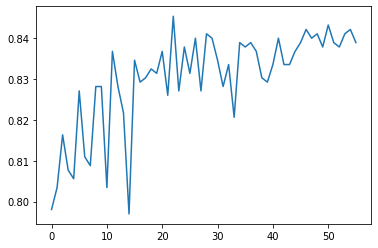

In [173]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate(test_data)
plt.show()

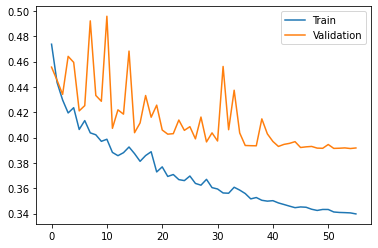

In [174]:
plt.plot(result.history['loss'], label='Train')
plt.plot(result.history['val_loss'], label='Validation')
plt.legend()

In [175]:
print(f'Test accuracy {test_result[2]:.2f}. Test AUC {test_result[1]:.2f}')

Test accuracy 0.82. Test AUC 0.81
